<a href="https://colab.research.google.com/github/SleepNeeded/LPR/blob/main/LPR_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

Import Library

In [70]:
!pip install ultralytics==8.0.20
!pip install -q keras-ocr

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.20 🚀 Python-3.10.12 torch-2.1.0+cu118 CPU
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 27.8/107.7 GB disk)


In [72]:
from ultralytics import YOLO
from IPython.display import display, Image

import os
from os import listdir

from tqdm import tqdm
import cv2
import PIL
from PIL import Image

from google.colab.patches import cv2_imshow
import gdown

import keras_ocr
import matplotlib.pyplot as plt
from math import sqrt

In [4]:
!gdown 1t7cOuxY0hhkJEUM2GGOB7VGLhdv7RPgf
!gdown 16yge-nWTZFqcSO7Cg_at37uEzvgU529O

Downloading...
From: https://drive.google.com/uc?id=1t7cOuxY0hhkJEUM2GGOB7VGLhdv7RPgf
To: /content/vehicle and license plate.v1i.yolov8.zip
100% 346M/346M [00:03<00:00, 92.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=16yge-nWTZFqcSO7Cg_at37uEzvgU529O
To: /content/file.zip
100% 19.5M/19.5M [00:00<00:00, 101MB/s] 


In [5]:
!unzip '/content/vehicle and license plate.v1i.yolov8.zip' -d 'datasets'
!unzip '/content/file.zip' -d 'pretrained_models'

Output streaming akan dipotong hingga 5000 baris terakhir.
 extracting: datasets/train/labels/21366793_jpg.rf.609b75a7446cb41b1994b8fdfc03aa74.txt  
 extracting: datasets/train/labels/21366793_jpg.rf.6f3479938f6623094c4964328b91bb8d.txt  
 extracting: datasets/train/labels/21366793_jpg.rf.901edb89fdfe9f8a9c25550c4396c127.txt  
 extracting: datasets/train/labels/21366793_jpg.rf.a69b7208e9100c6e1383e8277b577c0a.txt  
 extracting: datasets/train/labels/21366793_jpg.rf.e18b3fc3c4b56809b65773ef866d703c.txt  
 extracting: datasets/train/labels/21366793_jpg.rf.ed9474b7b157f5e4f32ed2d9718e4f52.txt  
 extracting: datasets/train/labels/21366793_jpg.rf.f0d2174e7f6cf49d7c94311f12ef713f.txt  
 extracting: datasets/train/labels/21366793_jpg.rf.f64f039f01034170263c8e95123ef556.txt  
 extracting: datasets/train/labels/21366798_jpg.rf.4bcbcb993cd558dd0e52ef1336303593.txt  
 extracting: datasets/train/labels/21366798_jpg.rf.67489d1711117ee4bbcb5d2f7e5ce974.txt  
 extracting: datasets/train/labels/213667

In [6]:
# model = YOLO('/content/yolov8n.pt')

# model.train(data='./datasets/data.yaml', epochs=20)

In [7]:
if not os.path.isdir('./cropped_images'):
  !mkdir './cropped_images'

Detect and crop license plate

In [51]:
!rm -r cropped_images
!mkdir cropped_images

In [55]:
model = YOLO('/content/pretrained_models/content/runs/detect/train3/weights/best.pt')

directory = './datasets/test/images/'

images = []

for image in tqdm(os.listdir(directory)):
  if (image.endswith(".jpg")):
    results = model.predict(directory + image)

    original_image = cv2.imread(directory + image)
    result_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

    for result in results[0].boxes.data.tolist():
      x1, y1, x2, y2, score, label = result
      if score > 0.5:
        # cv2.rectangle(result_image, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 4)
        roi_image = result_image[int(y1):int(y2), int(x1):int(x2)]
        roi_image = cv2.resize(roi_image, (100,30))
        cv2.imwrite('./cropped_images/' + ('cropped_' + image), roi_image)
    # cv2_imshow(result_image)

  0%|          | 0/21 [00:00<?, ?it/s]Ultralytics YOLOv8.0.20 🚀 Python-3.10.12 torch-2.1.0+cu118 CPU
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs
100%|██████████| 21/21 [00:06<00:00,  3.44it/s]


OCR for cropped plate

In [95]:
pipeline = keras_ocr.pipeline.Pipeline()

crop_directory = '/content/cropped_images/'

for cropped_image in os.listdir(crop_directory):
  # predicted_image = cv2.imread(crop_directory + cropped_image)
  # plate_gray = cv2.cvtColor(predicted_image, cv2.COLOR_BGR2GRAY)

  # _, plate_treshold = cv2.threshold(plate_gray, 120, 255, cv2.THRESH_BINARY +
  #                                           cv2.THRESH_OTSU)

  # cv2.imwrite('./temp.jpg', plate_treshold)

  target_image = keras_ocr.tools.read(crop_directory + cropped_image)
  # target_image = keras_ocr.tools.read('./temp.jpg')

  prediction_groups = pipeline.recognize([target_image])

  predictions = prediction_groups[0]

  plate_numbers = []
  section = []

  for prediction in predictions:

    x = (prediction[1][0][0] + prediction[1][1][0]) / 2
    y = (prediction[1][0][1] + prediction[1][1][1]) / 2

    distance = sqrt(y**2 + x**2)

    section.append({
        'text': prediction[0],
        'distance': distance,
        'y': y
    })

  if len(section) == 0:
    print("No Character Detected")
    continue

  highest = section[0]
  for i in range(1, len(section)):
    if section[i]['y'] > highest['y']:
      highest = section[i]

  threshold = 5
  for i in range(len(section)):
    if highest['y'] - section[i]['y'] <= threshold:
      if section[i] not in plate_numbers:
        plate_numbers.append(section[i])

  ordered_plate_number = []

  row = sorted(plate_numbers, key=lambda d: d['distance'])

  for each in row:
    ordered_plate_number.append(each['text'])

  for i in range(len(ordered_plate_number)):
    print(ordered_plate_number[i], end =" ")

  cv2_imshow(predicted_image)

# print(prediction_groups[0])

Looking for /root/.keras-ocr/craft_mlt_25k.h5
Looking for /root/.keras-ocr/crnn_kurapan.h5
1/1 [==============================] - 1s 707ms/step
No Character Detected
1/1 [==============================] - 3s 3s/step
b 2252 bzu 

1/1 [==============================] - 0s 479ms/step
b zuzoc 

1/1 [==============================] - 0s 243ms/step
No Character Detected
1/1 [==============================] - 0s 317ms/step
No Character Detected
1/1 [==============================] - 1s 1s/step
e 130s 

1/1 [==============================] - 1s 1s/step
b z119 

1/1 [==============================] - 1s 1s/step
d 

1/1 [==============================] - 1s 711ms/step
e 

1/1 [==============================] - 1s 942ms/step
5a 

1/1 [==============================] - 1s 914ms/step
es 

1/1 [==============================] - 1s 694ms/step
b toso hzot 

1/1 [==============================] - 0s 480ms/step
ql seon 

1/1 [==============================] - 1s 696ms/step
a 

1/1 [==============================] - 0s 276ms/step
ep 

1/1 [==============================] - 1s 703ms/step
t 1657 c 

1/1 [==============================] - 1s 702ms/step
eb 1816 abs 

1/1 [==============================] - 1s 727ms/step
isei 1g 

1/1 [==============================] - 1s 1s/step
b 

1/1 [==============================] - 1s 1s/step
b sst tod 

1/1 [==============================] - 1s 924ms/step
b ioll ens 

<Axes: >

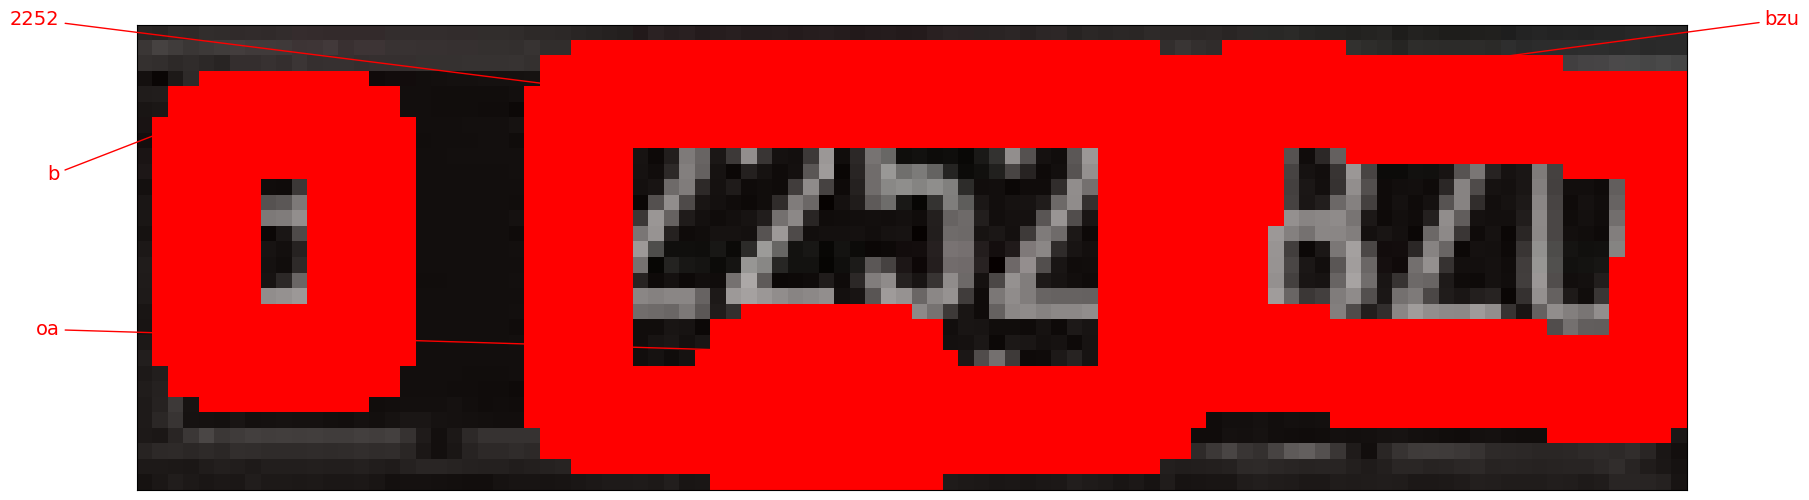

In [69]:
# print(prediction_groups[0][3])

_, ax = plt.subplots(nrows=1, figsize=(20, 20))
keras_ocr.tools.drawAnnotations(image=target_image, predictions=prediction_groups[0], ax=ax)